# Using Wavelet Filter (B-Spline) for spot selection


In this notebook I am using the Wavelet filter (B-Spline) for spot selection from cell images.  This is a very common approach using in DSP.
For this I am going to use  B-Spline basis function  of 3rd order and scaling factor 2.
In this notebook v0 will be the original image, g1 and g2 are the filter kernels of size 5 and 9,  respectively . They will be used to perform convolution of the images using separable kernels.  The convoluted images will be used to calculate the wavelet transforms at level 1 and level 2. 

v0 = Original image

g1 =  level 1 filter kernel =  [1/16,1/4,3/8,1/4,1/16]

g2 =  level 2 filter kernel =  [1/16,0,1/4,0,3/8,0,1/4,0,1/16]

$v1 =  (v0 * g1)*g1^T$

$v2 = (v1 *g2)*g2^T$

w1 = (v0 - v1)  wavelet transform at level 1

w2 = (v1 - v2) wavelet transform at level 2

w1 mostly contains all the noise information and can be used to select a threshold for spot detection.

w2 contain information about objects that are close to diffraction limit, and hence w2 is used for detecting the spots rather than the original image.




# Import

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import misc
from scipy.ndimage import filters
from skimage.feature import peak_local_max
import warnings
warnings.filterwarnings("ignore")

# Loading and displaying the data

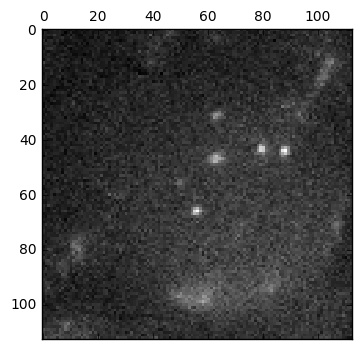

In [3]:
data = misc.imread('small_tiff.tif').astype('i2')
plt.matshow(data,cmap='gray')
plt.show()

# Input image and the filters

In [5]:
v0 = data
g1 = np.array([1/16,1/4,3/8,1/4,1/16])
g2 = np.array([1/16,0,1/4,0,3/8,0,1/4,0,1/16])

# Convolution of the image

In [6]:
v1 = filters.convolve1d(filters.convolve1d(v0,g1,axis=1),g1,axis=0)
v2 = filters.convolve1d(filters.convolve1d(v1,g2,axis=1),g2,axis=0)

### Convolution of v0 with g1

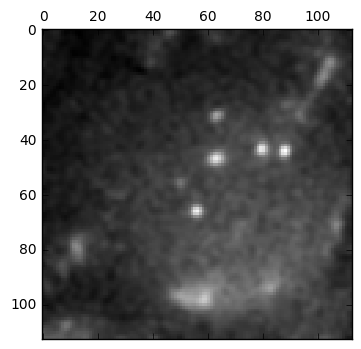

In [7]:
plt.matshow(v1,cmap='gray')
plt.show()

### Convoultion of v1 with g2

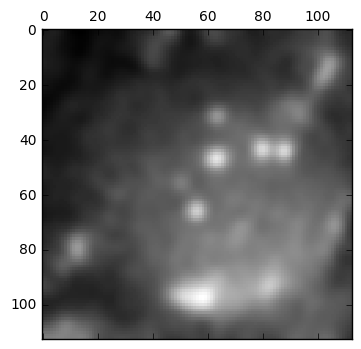

In [9]:
plt.matshow(v2,cmap='gray')
plt.show()

## First wavelet transform
The image mostly contain information about the noise/backrgound. It will be used to select a threshold for spot detection.

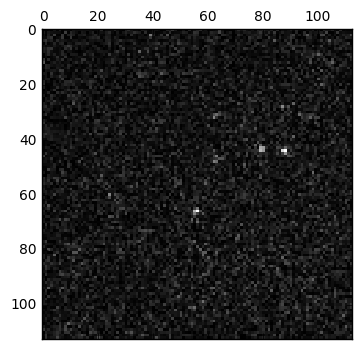

In [14]:
w1 = np.abs(v0-v1)
plt.matshow(w1,cmap='gray')
plt.show()

## Second wavelet transform
This image contains information about diffraction limited objects. The spots appear bright and will be used for spot selection.

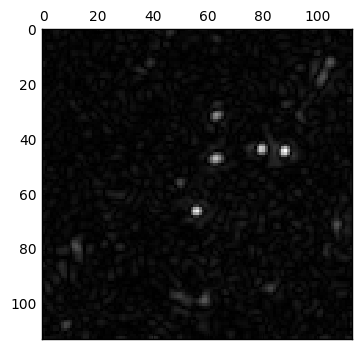

In [16]:
w2 = np.abs(v1-v2)
plt.matshow(w2,cmap='gray')
plt.show()

## Statistics on the wavelet transforms

In [22]:
print ("Mean of w1 = {}".format(np.mean(w1)))
print ("Std Dev of w1 = {}".format(np.std(w1)))
print ("Mean of w2 = {}".format(np.mean(w2)))
print ("Std Dev of w2 = {}".format(np.std(w2)))

Mean of w1 = 60.817918396115594
Std Dev of w1 = 48.1353877933193
Mean of w2 = 18.429634270498866
Std Dev of w2 = 23.703904534293205


## Spot detection
Based on the statistics above I am picking a threshold of np.mean(w1)+2.5*np.std(w1)
I also exclude spots that are within 10 pixels of the border.

In [30]:
coordinates = peak_local_max(w2, min_distance=2,threshold_abs=np.mean(w1)+2.5*np.std(w1),exclude_border=10)
print ("Number of spots detected = {}".format(len(coordinates)))

Number of spots detected = 5


## Plotting the selected spots on the original image

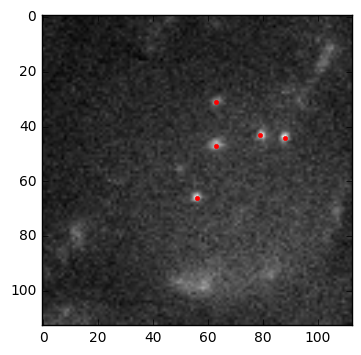

In [32]:
plt.imshow(v0, cmap=plt.cm.gray)
plt.autoscale(False)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.show()

## Displaying all the spots found
Here I am selecting 4 pixels on either side of the spots and saving only these spot images as stacked tiff.



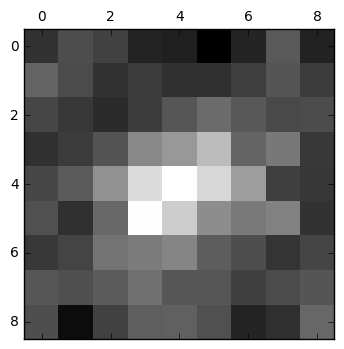

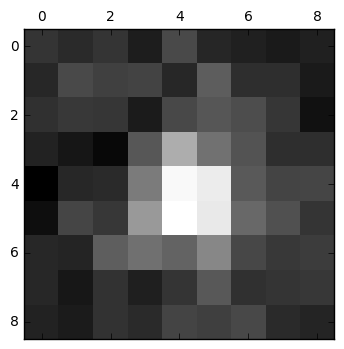

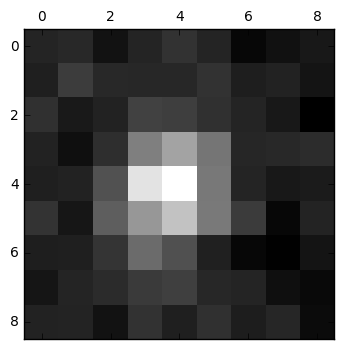

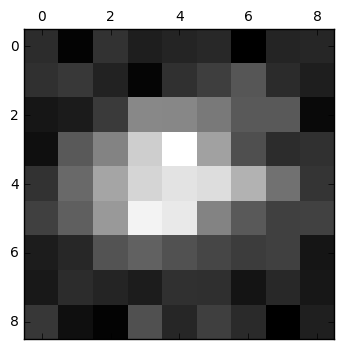

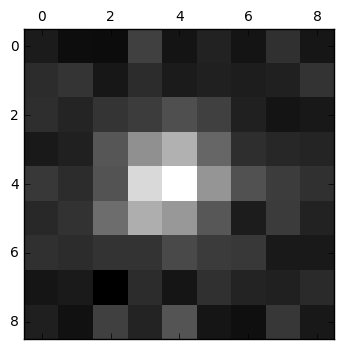

In [34]:
for i in coordinates:
    no_pixels = 4
    j1 = data[i[0]-no_pixels:i[0]+no_pixels+1,i[1]-no_pixels:i[1]+no_pixels+1]
    plt.matshow(j1,cmap='gray')

## Saving the spots
I am saving all the spot images in an array

In [38]:
import numpy as np
no_pixels = 4
image = np.zeros((2*no_pixels+1,2*no_pixels+1,len(coordinates)), 'i2')
for j,i in enumerate(coordinates):
    j1=data[i[0]-no_pixels:i[0]+no_pixels+1,i[1]-no_pixels:i[1]+no_pixels+1]
    image[:,:,j] = j1


## Writing the spot images to a stacked tiff file

In [39]:
from tifffile import imsave
imsave('multipage.tif', image.T,metadata={'axes': 'XYZ'})

# Loading the stacked tiff file
Here I load the tiff file that we have created and display all the spot images in it.

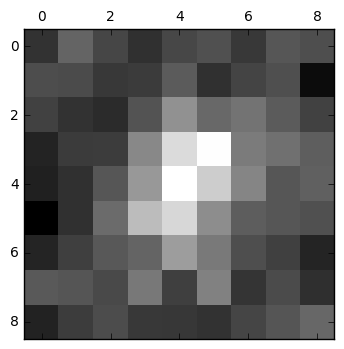

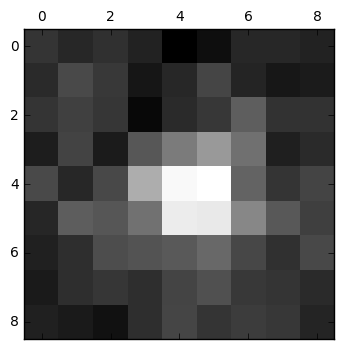

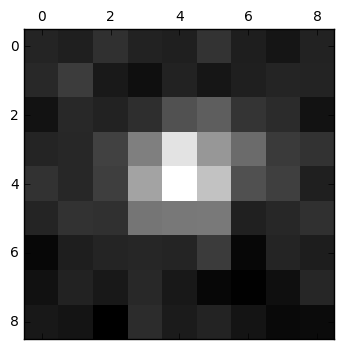

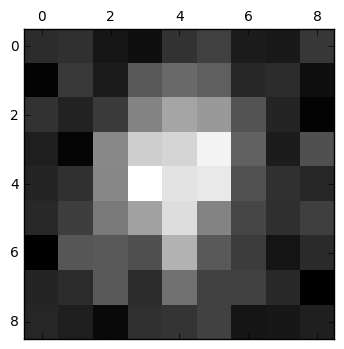

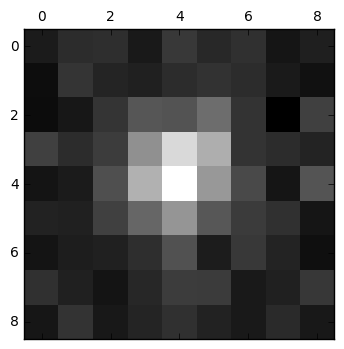

In [40]:
from tifffile import TiffFile
with TiffFile('multipage.tif') as tif:
    images = tif.asarray()
    for page in tif:
        image = page.asarray()
        #print(image.shape)
        plt.matshow(image,cmap='gray')
        

In [41]:
print ("The size of the stacked image = {}".format(images.T.shape))

The size of the stacked image = (9, 9, 5)
